### Import libraries

In [1]:
import astropy.io.fits as pyfits

import os
import pickle
import numpy as np
import pandas as pd
from skimage.feature import blob_log
import matplotlib.pyplot as plt
%matplotlib inline

### Read label file

In [2]:
label_file = "R_filtrid/BD_decomp_asi.txt"
galaxies_info = pd.read_table(label_file,header=None,index_col=False,skiprows=1)
part1 = galaxies_info.loc[galaxies_info[1].isnull(),[0,2,3,4,5,6]]
part1.columns = ["cnr","kval","varb","dust","popul","rescale"]
part2 = galaxies_info.loc[galaxies_info[1].notnull(),[0,1,2,3,4,5]]
part2.columns = ["cnr","kval","varb","dust","popul","rescale"]
galaxies_info = part1.append(part2)
galaxies_info.head()

,cnr,kval,varb,dust,popul,rescale
0,105,2.0,0,T,T,F
1,106,1.0,1,F,F,F
2,107,2.0,0.2,F,T,F
3,108,1.5,0,F,T,F
4,113,2.0,0,F,T,F


### Read fits files, log transform

In [49]:
galaxies_fits = []
path = "R_filtrid/"
a=1000
log_transform = True
for num in galaxies_info['cnr']:
    fits_file = pyfits.getdata(path+str(num)+".fits")
    if log_transform:
        fits_file = np.log(a*(fits_file-fits_file.min())/(fits_file.max()-fits_file.min())+1)/np.log(a)
    galaxies_fits.append(fits_file)

### Display examples

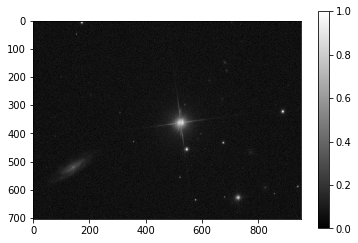

In [192]:
plt.imshow(galaxies_fits[7], cmap='gray')
plt.colorbar()

### Blob detection

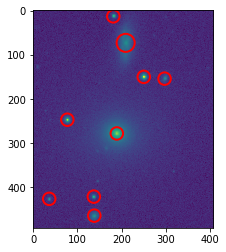

In [426]:
image_gray = galaxies_fits[4]
image_gray = (image_gray-np.min(image_gray))/(np.max(image_gray)-np.min(image_gray))
blobs_log =  blob_log(image_gray, max_sigma=50, min_sigma = 10, threshold=.05)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
fig, ax = plt.subplots()
ax.imshow(image_gray)
for blob in blobs_log:
        y, x, r = blob
        circle = plt.Circle((x, y), r, color = 'red', linewidth=2, fill=False)
        ax.add_patch(circle)

In [427]:
# to delete
df = pd.DataFrame(blobs_log)
df['dist'] = np.sqrt((df[0]-image_gray.shape[0])**2+(df[1]-image_gray.shape[1])**2)
df['br'] = [np.mean(image_gray[np.max([0,int(x-r)]):np.min([image_gray.shape[0],int(x+r)]),
                               np.max([0,int(y-r)]):np.min([image_gray.shape[1],int(y+r)])]) for [x,y,r] in blobs_log]  
df['br2'] = [np.mean(image_gray[np.max([0,int(x-2*r)]):np.min([image_gray.shape[0],int(x+2*r)]),
                               np.max([0,int(y-2*r)]):np.min([image_gray.shape[1],int(y+2*r)])]) for [x,y,r] in blobs_log]
df['sd'] = [np.std(image_gray[np.max([0,int(x-r)]):np.min([image_gray.shape[0],int(x+r)]),
                               np.max([0,int(y-r)]):np.min([image_gray.shape[1],int(y+r)])]) for [x,y,r] in blobs_log] 
df['br*sd'] = df['br']*df['sd']
df['br/sd'] = df['br']/df['sd']
df['brbr/sd'] = df['br']**3/df['sd']
df['sc_r'] = df[2]/np.sqrt(image_gray.shape[0]**2+image_gray.shape[1]**2)
df['r*br/sd'] = df['sc_r']*df['br']/df['sd']
df['r*br'] = df['sc_r']*df['br']
df['r*br/sd'] = df['sc_r']*df['br']**3/df['sd']
df

,0,1,2,dist,br,br2,sd,br*sd,br/sd,brbr/sd,sc_r,r*br/sd,r*br
0,464.0,138.0,14.142136,271.447969,0.236826,0.156621,0.079852,0.018911,2.965824,0.166342,0.022126,0.003680,0.005240
1,426.0,36.0,14.142136,377.809476,0.139706,0.122806,0.064998,0.009081,2.149375,0.041951,0.022126,0.000928,0.003091
2,421.0,137.0,14.142136,280.146390,0.168250,0.137887,0.092820,0.015617,1.812647,0.051312,0.022126,0.001135,0.003723
3,278.0,189.0,14.142136,306.197649,0.521012,0.373854,0.098885,0.051520,5.268896,1.430262,0.022126,0.031646,0.011528
4,247.0,77.0,14.142136,411.808208,0.232890,0.167010,0.140928,0.032821,1.652553,0.089631,0.022126,0.001983,0.005153
5,154.0,297.0,14.142136,355.759750,0.181770,0.142790,0.063109,0.011471,2.880260,0.095164,0.022126,0.002106,0.004022
6,150.0,250.0,14.142136,376.733327,0.249833,0.167279,0.159432,0.039831,1.567023,0.097808,0.022126,0.002164,0.005528
7,73.0,209.0,20.427529,463.855581,0.297454,0.206312,0.076484,0.022750,3.889106,0.344103,0.031960,0.010997,0.009507
8,13.0,181.0,14.142136,530.066034,0.163421,0.144241,0.096613,0.015789,1.691511,0.045174,0.022126,0.001000,0.003616


### Run blob detection for all

In [431]:
scale=1
galaxy_circles = []
for image in galaxies_fits:  
    # scale image to range 0-1
    image_norm = (image-np.min(image))/(np.max(image)-np.min(image))
    # diagonal of the image in pixels
    diag = np.sqrt(image_norm.shape[0]**2+image_norm.shape[1]**2)
    # detect blobs
    blobs_log = blob_log(image_norm, min_sigma=10, max_sigma=50, threshold=.05)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    # delete blobs exceeding edges
    blobs_log = np.array([[x,y,r] for [x,y,r] in blobs_log if x-r>0 and x+r<image_norm.shape[0] and y-r>0 and y+r<image_norm.shape[1]])
    score = 0
    circle_coords = (0,0,0)
    # select the biggest and brightest blob
    for blob in blobs_log: 
        r=round(blob[2],0)
        r_sc = blob[2]/diag
        avg_light = np.mean(image_norm[np.max([0,int(blob[0]-scale*r)]):np.min([image_norm.shape[0],int(blob[0]+scale*r)]),
                                           np.max([0,int(blob[1]-scale*r)]):np.min([image_norm.shape[1],int(blob[1]+scale*r)])])
        im_score = (avg_light*r_sc)
        if im_score > score:
            score = im_score
            circle_coords = blob
    galaxy_circles.append(circle_coords)

# save results
pickle.dump(galaxy_circles, open( "galaxy_circles_v0.p", "wb" ) )

In [46]:
# load previously saved results without recalculation
galaxy_circles = pickle.load( open( "galaxy_circles_v0.p", "rb" ) )

In [ ]:
# ordinary plots
count = 28
fig, ax = plt.subplots(int(np.ceil(count/4)), 4,figsize = (16,4*int(np.ceil(count/4)+1)))
for i in range(int(np.ceil(count/4))):
    for j in range(4):
        if i*4+j<count:
            ax[i][j].imshow(galaxies_fits[i*4+j], cmap='gray')
            y, x, r = galaxy_circles[i*4+j]
            circle = plt.Circle((x, y), r*2, color = 'red', linewidth=2, fill=False)
            ax[i][j].set_title(str(i*4+j))
            ax[i][j].add_patch(circle)
plt.show()

IndexError: list index out of range

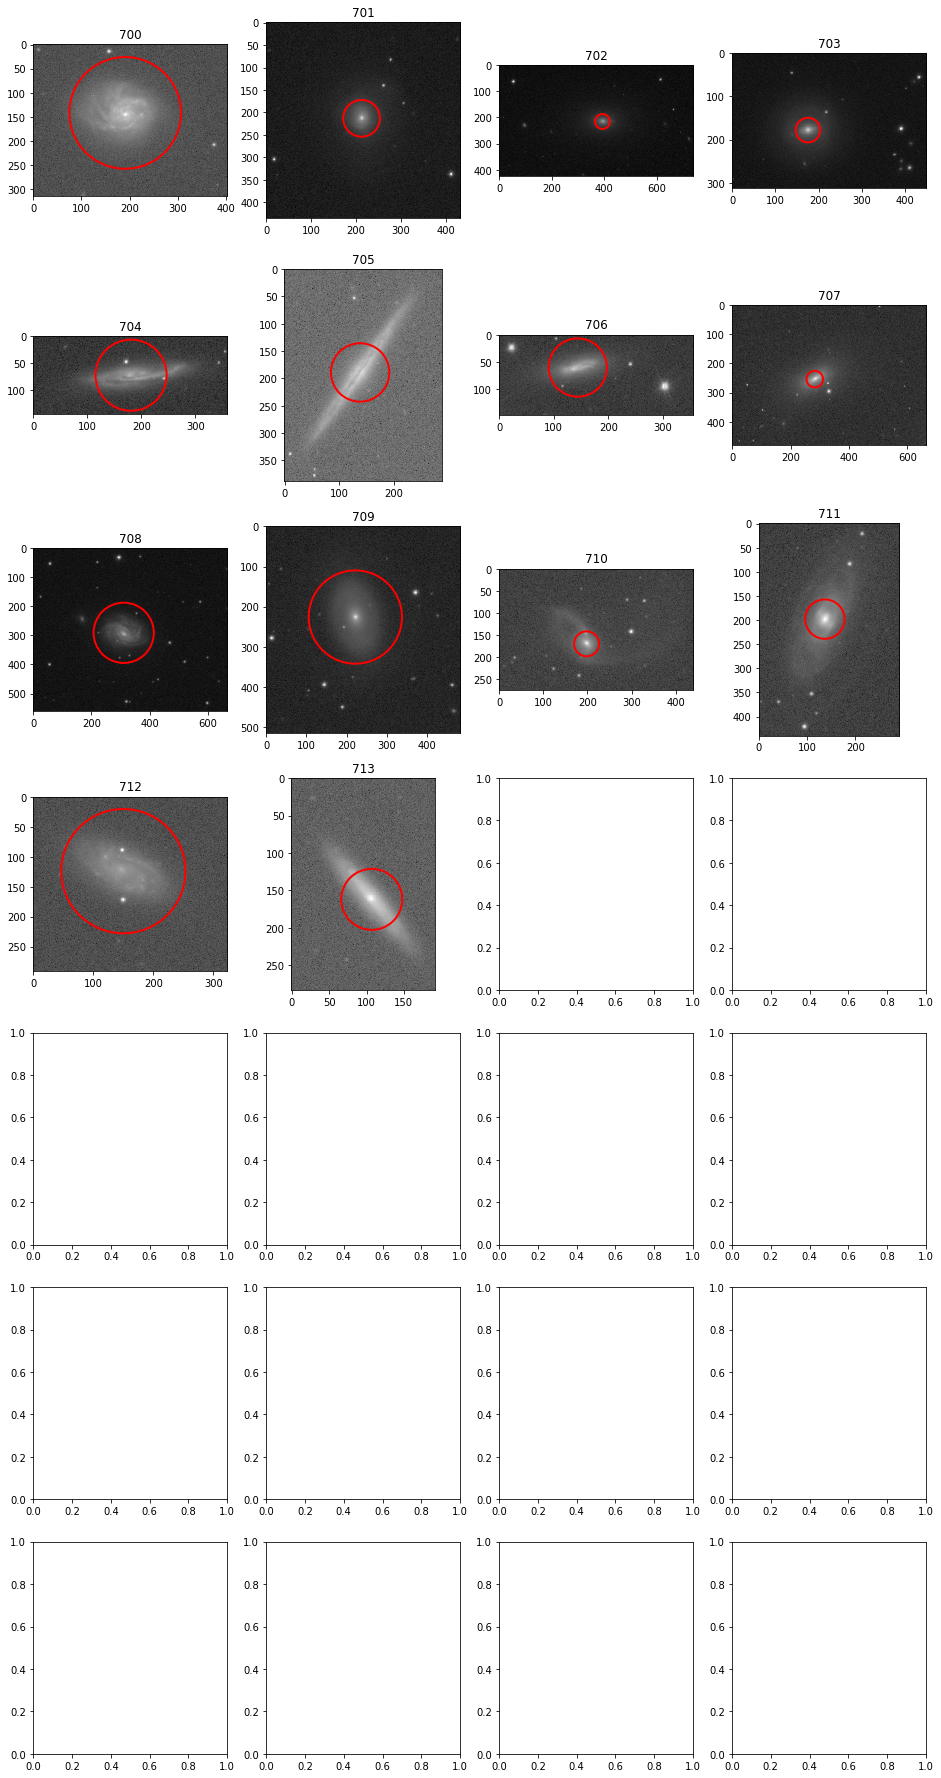

In [32]:
# go through all images
subset = 25
count = 28
fig, ax = plt.subplots(int(np.ceil(count/4)), 4,figsize = (16,4*int(np.ceil(count/4)+1)))
for i in range(int(np.ceil(count/4))):
    for j in range(4):
        if i*4+j<count:
            ax[i][j].imshow(galaxies_fits[subset*count+i*4+j], cmap='gray')
            y, x, r = galaxy_circles[subset*count+i*4+j]
            circle = plt.Circle((x, y), r*2, color = 'red', linewidth=2, fill=False)
            ax[i][j].set_title(str(subset*count+i*4+j))
            ax[i][j].add_patch(circle)
plt.show()

### Collect mistakes

In [48]:
# From visual inspection:
wrong_id = [7,31,115,116,135,193,207,215,254,334,351,401,411,459,481,580,585,601,614,663,677,695]
double_unknown = [35,38,103,116,124,142,172,179,183,191,197,198,227,282,305,306,325,376,381,451,459,463,508,520,543,563,564,
                 582,588,621,648,655,675,676]
double_double = [72,106,165,201,280,557]
double_check = [42,56,69,144,217,229,236,237,278,284,312,318,368,374,454,513,549,561,565,569,587,598,628]
print(len(wrong_id), len(double_unknown), len(double_double), len(double_check))

22 34 6 23


### Read masks

In [ ]:
galaxies_masks = []
path = "Masks/"
for num in galaxies_info['cnr']:
    fits_file = pyfits.getdata(path+str(num)+".fits")
    galaxies_masks.append(fits_file)

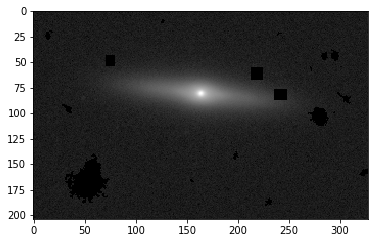

In [50]:
i=5
a=1000
img = np.multiply(galaxies_fits[i],galaxies_masks[i])
img_norm = (img-img.min())/(img.max()-img.min())
#log_img = np.log(a*img_norm+1)/np.log(a)
plt.imshow(img_norm, cmap='gray')

### Correct mistakes and ambiguities

In [53]:
error_indexes = wrong_id + double_check + double_double + double_unknown

for i in error_indexes:
    image = np.multiply(galaxies_fits[i],galaxies_masks[i])
    image_norm = (image-np.min(image))/(np.max(image)-np.min(image))
    diag = np.sqrt(image_norm.shape[0]**2+image_norm.shape[1]**2)
    blobs_log = blob_log(image_norm, min_sigma=10, max_sigma=50, threshold=.05)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    blobs_log = np.array([[x,y,r] for [x,y,r] in blobs_log if x-r>0 and x+r<image_norm.shape[0] and y-r>0 and y+r<image_norm.shape[1]])
    score = 0
    scale = 1
    circle_coords = (0,0,0)
    for blob in blobs_log: 
        r=round(blob[2],0)
        r_sc = blob[2]/diag
        avg_light = np.mean(image_norm[np.max([0,int(blob[0]-scale*r)]):np.min([image_norm.shape[0],int(blob[0]+scale*r)]),
                                           np.max([0,int(blob[1]-scale*r)]):np.min([image_norm.shape[1],int(blob[1]+scale*r)])])
        im_score = (avg_light*r_sc)
        if im_score > score:
            score = im_score
            circle_coords = blob
    galaxy_circles[i] = circle_coords

### Make sure no mistakes are left

IndexError: list index out of range

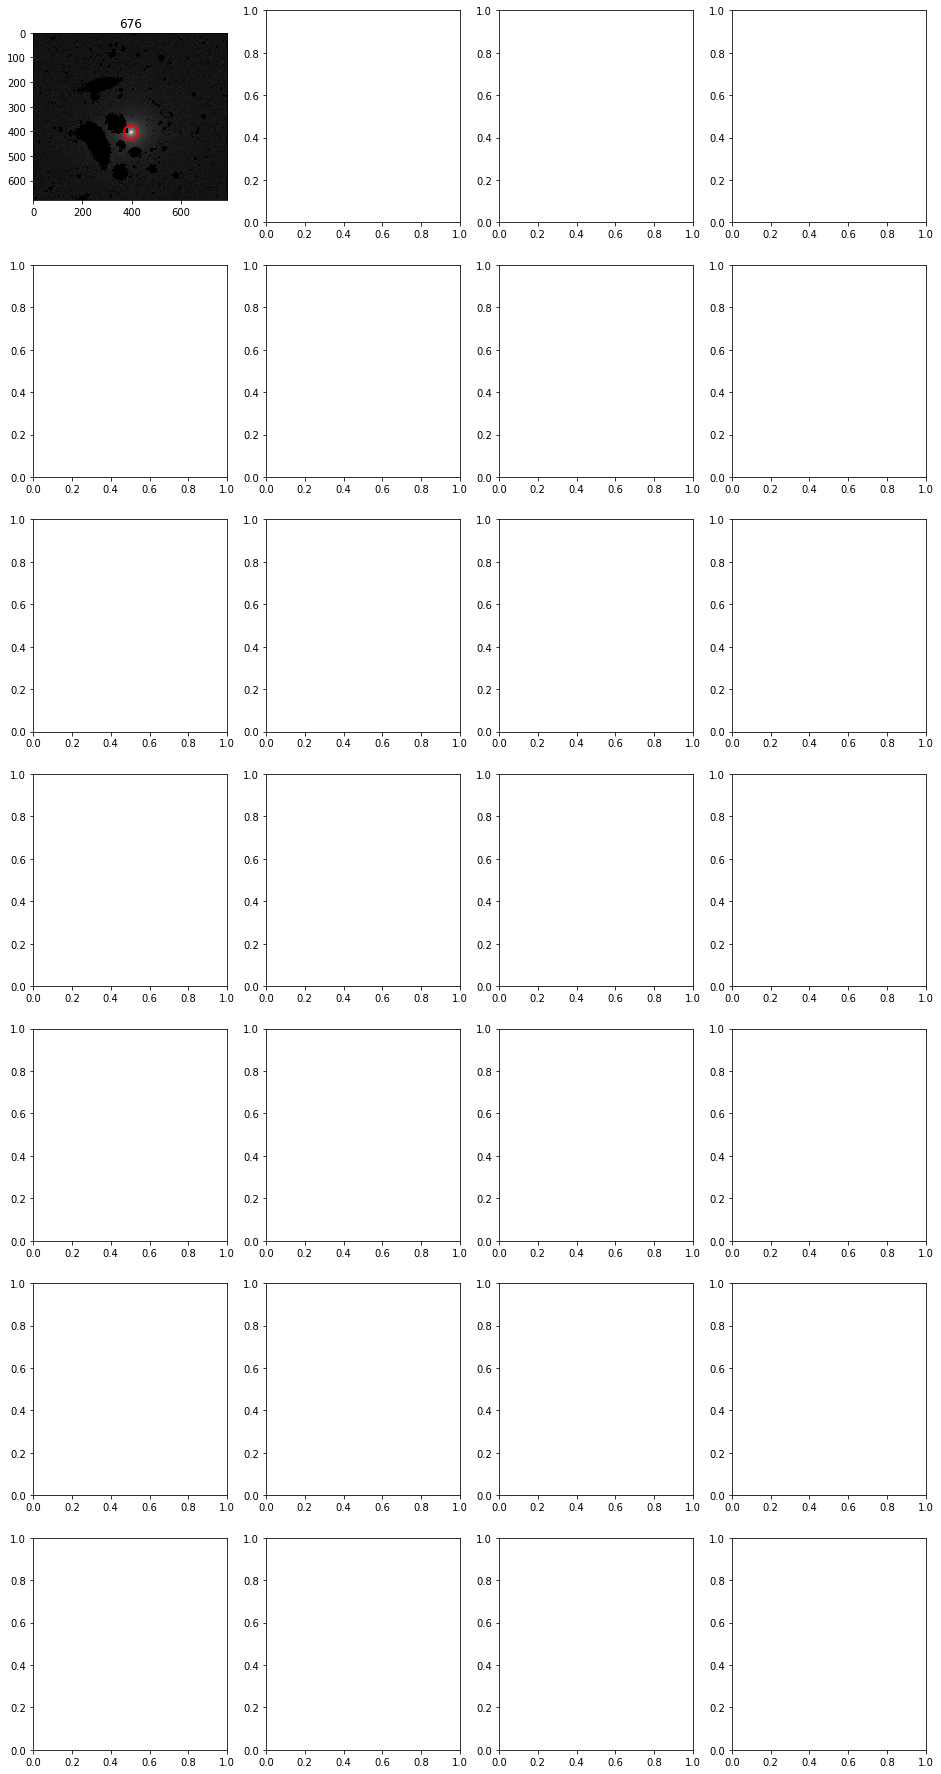

In [59]:
# go through all images
subset = 3
count = 28
fig, ax = plt.subplots(int(np.ceil(count/4)), 4,figsize = (16,4*int(np.ceil(count/4)+1)))
for i in range(int(np.ceil(count/4))):
    for j in range(4):
        if i*4+j<count:
            ax[i][j].imshow(np.multiply(galaxies_fits[error_indexes[subset*count+i*4+j]],galaxies_masks[error_indexes[subset*count+i*4+j]]), cmap='gray')
            y, x, r = galaxy_circles[error_indexes[subset*count+i*4+j]]
            circle = plt.Circle((x, y), r*2, color = 'red', linewidth=2, fill=False)
            ax[i][j].set_title(str(error_indexes[subset*count+i*4+j]))
            ax[i][j].add_patch(circle)
plt.show()

### Correct last mistakes by hand

In [119]:
last_err = [351,401,585,695,56,312,569,197,543]

array([[ 343.        ,  262.        ,   51.85449729],
       [ 328.        ,  315.        ,   32.99831646],
       [ 265.        ,  186.        ,   14.14213562],
       [ 264.        ,  368.        ,   20.42752923],
       [ 241.        ,  168.        ,   20.42752923],
       [ 190.        ,  407.        ,   64.42528451],
       [ 189.        ,  153.        ,   14.14213562],
       [ 145.        ,  179.        ,   20.42752923],
       [ 136.        ,  371.        ,   26.71292284],
       [  72.        ,  225.        ,   14.14213562],
       [  68.        ,  270.        ,   20.42752923],
       [  67.        ,  308.        ,   20.42752923],
       [   0.        ,  239.        ,   70.71067812]])

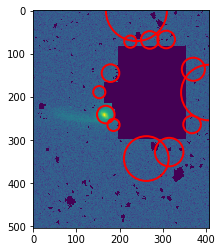

In [111]:
i=543
image_gray = np.multiply(galaxies_fits[i],galaxies_masks[i])
image_gray = (image_gray-np.min(image_gray))/(np.max(image_gray)-np.min(image_gray))
blobs_log =  blob_log(image_gray, max_sigma=50, min_sigma = 10, threshold=.05)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
fig, ax = plt.subplots()
ax.imshow(image_gray)
for blob in blobs_log:
        y, x, r = blob
        circle = plt.Circle((x, y), r, color = 'red', linewidth=2, fill=False)
        ax.add_patch(circle)
blobs_log

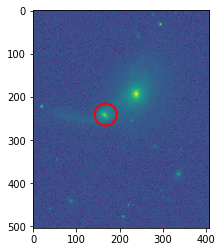

In [114]:
fig, ax = plt.subplots()
ax.imshow(galaxies_fits[i])
y,x,r = blobs_log[4]+np.array([0,0,5])
circle = plt.Circle((x, y), r, color = 'red', linewidth=2, fill=False)
ax.add_patch(circle)

In [115]:
galaxies_info['cnr'][i]

1802

In [116]:
galaxy_circles[i] = blobs_log[4]+np.array([0,0,5])

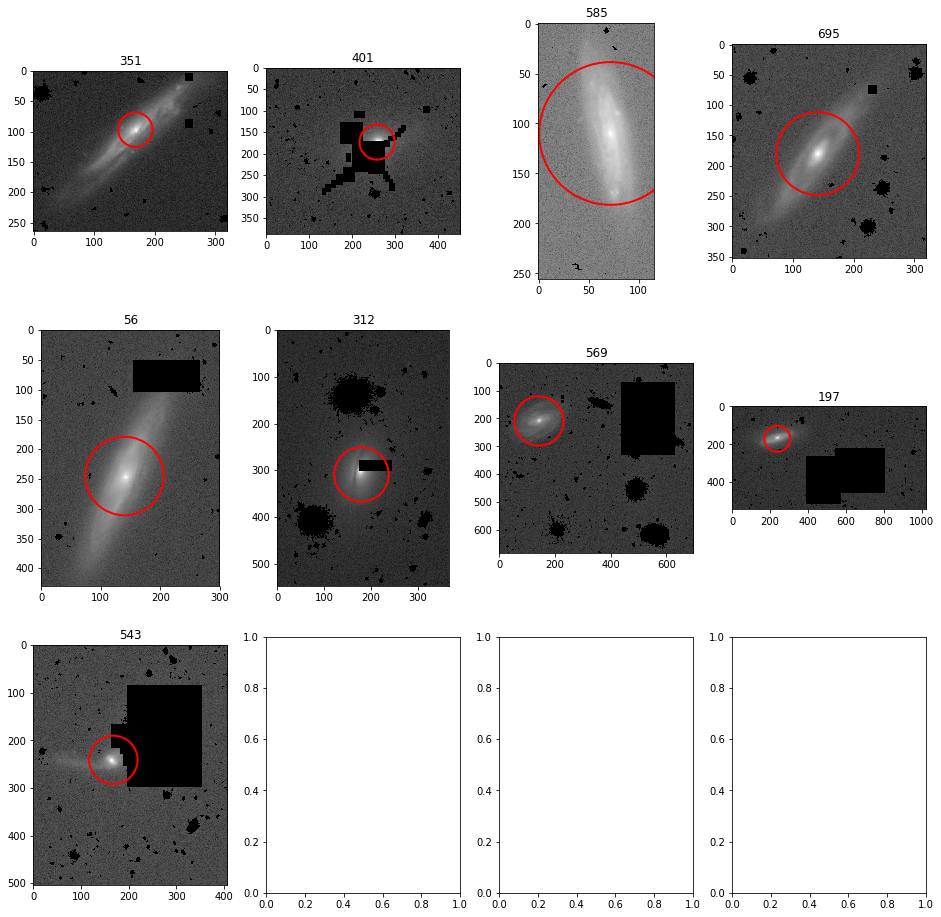

In [120]:
# go through all images
subset = 0
count = len(last_err)
fig, ax = plt.subplots(int(np.ceil(count/4)), 4,figsize = (16,4*int(np.ceil(count/4)+1)))
for i in range(int(np.ceil(count/4))):
    for j in range(4):
        if i*4+j<count:
            ax[i][j].imshow(np.multiply(galaxies_fits[last_err[subset*count+i*4+j]],galaxies_masks[last_err[subset*count+i*4+j]]), cmap='gray')
            y, x, r = galaxy_circles[last_err[subset*count+i*4+j]]
            circle = plt.Circle((x, y), r*2, color = 'red', linewidth=2, fill=False)
            ax[i][j].set_title(str(last_err[subset*count+i*4+j]))
            ax[i][j].add_patch(circle)
plt.show()

### Save results

In [121]:
pickle.dump(galaxy_circles, open( "galaxy_circles_v1.p", "wb" ) )